In [73]:
# run_smemp_apf.ipynb
# Script to run Specmatch-Emp model on APF spectra and output results including derived stellar properties 
# and residual between target and best matching spectra.
# Last modified ?? by Anna Zuckerman
#
# NOTE: This script is modified from smemp_multifile.ipynb (itself modified from C.N's smemp.py). Modifications from smemp.py include added ability to process mulitple stellar
#      targets from a directory, new deblazing function, option to simplistically remove cosmic rays, and new output
#      files including output of residual. See project project write-up for details.  
#      Modifications are noted by the initials ADZ and the date.
# Input: path to a directory containing APF fits spectra files. If more than one file corresponds to a star, 
#      they must be grouped into a subdirectory.
# Output: Specmatch-emp derived Stellar properties in specmatch_results.csv, fits file for each star containing normalized,
#       deblazed target spectrum, residual between target sepctrum and linear combinatino of best matching spectra, and 
#       shifted wavelength scale. Also produces a log file. Please update file paths for these if needed before running.

In [37]:
# ADZ: allow importing .ipynb scripts 
!pip install import-ipynb

In [160]:
# standard imports
import import_ipynb #ADZ ADD 6/23/20
import pandas as pd #ADZ ADD 7/13/20
from astroquery.simbad import Simbad #ADZ ADD 8/6/20
import sys, os
from os import listdir
from os.path import isfile, join
import csv
from pylab import *
import pylab
from scipy import signal
import astropy.io.fits as pf
from astropy.io import fits
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.units as units
from astropy.coordinates import SkyCoord
import copy
import glob
import h5py,pdb
import pyvo
import datetime

# Specmatch imports (relative to current directory)
sys.path.insert(0, '/mnt_home/azuckerman/BL_APF_DAP/specmatch_emp')
from specmatch_emp.specmatchemp import library
from specmatch_emp.specmatchemp import plots as smplot
from specmatch_emp.specmatchemp.spectrum import Spectrum
from specmatch_emp.specmatchemp.specmatch import SpecMatch

# Isoclassify imports
os.environ['DUST_DIR'] = '/mnt_home/azuckerman/BL_APF_DAP/mwdust/dust_dir'
import mwdust
from isoclassify.direct import classify as classify_direct
from isoclassify.grid import classify as classify_grid
from isoclassify import DATADIR
PACKAGEDIR = '/mnt_home/azuckerman/BL_APF_DAP/isoclassify/isoclassify'

# Other local imports
#from deblaze import afs_deblaze # ADZ comment out
from rescale import get_rescaled_wave_soln
from rescale import resample
from optparse import OptionParser
from bstar_deblaze import bstar_deblazed2 #ADZ ADD 7/17/20

# define an exception to use in reading in filenames
class HIP_name_Exception(Exception):
    pass

# define an exception if iodine is found in the spectrum
class Iodine_Exception(Exception):
    pass

In [75]:
'''
Teff_trend = np.poly1d(np.loadtxt('Teff_trend.csv'))
feh_trend = np.poly1d(np.loadtxt('feh_trend.csv'))
R_R_trend = np.poly1d(np.loadtxt('R_R_trend.csv'))
detrend_uncertainties = np.loadtxt('detrended_parameter_RMSE_values.csv', delimiter = ',', dtype = float, skiprows = 1, usecols = (1,2,3))
Teff_det_u = detrend_uncertainties[0]
feh_det_u = detrend_uncertainties[1]
R_det_u = detrend_uncertainties[2]

def detrend(sm):  
    Teff_detrended = sm.results['Teff'] + Teff_trend(sm.results['Teff'])
    feh_detrended = sm.results['feh'] + feh_trend(sm.results['feh'])
    if sm.results['radius'] < 1 or sm.results['radius'] > 2:
        R_detrended = sm.results['radius']
    else:
        R_detrended = sm.results['radius'] + R_R_trend(sm.results['radius'])*sm.results['radius']
    return Teff_detrended, feh_detrended, R_detrended
'''

"\nTeff_trend = np.poly1d(np.loadtxt('Teff_trend.csv'))\nfeh_trend = np.poly1d(np.loadtxt('feh_trend.csv'))\nR_R_trend = np.poly1d(np.loadtxt('R_R_trend.csv'))\ndetrend_uncertainties = np.loadtxt('detrended_parameter_RMSE_values.csv', delimiter = ',', dtype = float, skiprows = 1, usecols = (1,2,3))\nTeff_det_u = detrend_uncertainties[0]\nfeh_det_u = detrend_uncertainties[1]\nR_det_u = detrend_uncertainties[2]\n\ndef detrend(sm):  \n    Teff_detrended = sm.results['Teff'] + Teff_trend(sm.results['Teff'])\n    feh_detrended = sm.results['feh'] + feh_trend(sm.results['feh'])\n    if sm.results['radius'] < 1 or sm.results['radius'] > 2:\n        R_detrended = sm.results['radius']\n    else:\n        R_detrended = sm.results['radius'] + R_R_trend(sm.results['radius'])*sm.results['radius']\n    return Teff_detrended, feh_detrended, R_detrended\n"

In [161]:
#def write_results(fd_raw, fd_detrended, my_spectrum, sm, write_new = False):
def write_results(fd, my_spectrum, sm, iso_results, HIP_name, filenames, Teff_bounds_flag, R_bounds_flag, 
                  SNR, iodine_flag, iso_fail_flag, warnings, write_new = False): 
                 
    """
    Write to a csv the derived properties of a target following
    the SpecMatch process
    Args:
        fd(File): object for the csv file to write detrended and un-detrended stellar property results to
        my_spectrum (spectrum.Spectrum): Target spectrum
        sm (specmatch.SpecMatch): Contains results of the algorithm
        write_new (Boolean): Whether to write to a new csv file
    """
    
    fieldnames = ['name','HIP_name', 'filenames', 'SNR', 'iodine_flag', 'failure_code', 'failure_message', 'iso_fail_flag',
                  'warnings', 'Teff_bounds_flag', 'R_bounds_flag', 
                  'Teff', 'u_Teff', 'Teff_detrended', 'u_Teff_detrended', 'iso_Teff', 'iso_up_Teff', 'iso_um_Teff', 
                  'radius','u_radius', 'radius_detrended', 'u_radius_detrended', 'iso_radius', 'iso_up_radius', 'iso_um_radius',
                  'feh','u_feh', 'feh_detrended','u_feh_detrended', 'iso_feh', 'iso_up_feh', 'iso_um_feh',
                  'logg', 'u_logg', 'logg_detrended', 'u_logg_detrended', 'iso_logg', 'iso_up_logg', 'iso_um_logg',
                  'mass', 'u_mass', 'mass_detrended', 'u_mass_detrended', 'iso_mass', 'iso_up_mass', 'iso_um_mass',
                  'age', 'u_age', 'age_detrended', 'u_age_detrended', 'iso_age', 'iso_up_age', 'iso_um_age',
                  'best_mean_chi_squared']

    thewriter = csv.DictWriter(fd, fieldnames=fieldnames)

    if (write_new): thewriter.writeheader()

    thewriter.writerow({'name' : my_spectrum.name,
                        'HIP_name': HIP_name,
                        'filenames': filenames,
                        'SNR': SNR,
                        'iodine_flag': iodine_flag, # At least one spectrum for this star had iodine; do not trust results
                        'failure_code': 0, # Did not fail (sucessfully ran SM-Emp on this star)
                        'failure_message': 'No failure',
                        'iso_fail_flag': iso_fail_flag,
                        'warnings': warnings,
                        'Teff_bounds_flag': Teff_bounds_flag,
                        'R_bounds_flag': R_bounds_flag,
                        'Teff' : '{0:.3f}'.format(sm.results_nodetrend['Teff']),
                        'u_Teff' : '{0:.3f}'.format(sm.results_nodetrend['u_Teff']),
                        'Teff_detrended' : '{0:.3f}'.format(sm.results['Teff']),
                        'u_Teff_detrended' : '{0:.3f}'.format(sm.results['u_Teff']),      
                        'iso_Teff' : '{0:.3f}'.format(iso_results.teff),
                        'iso_up_Teff' : '{0:.3f}'.format(iso_results.teffep), # plus uncertianty
                        'iso_um_Teff' : '{0:.3f}'.format(iso_results.teffem), # minus uncertianty
                        'radius' : '{0:.3f}'.format(sm.results_nodetrend['radius']),
                        'u_radius' : '{0:.3f}'.format(sm.results_nodetrend['u_radius']),
                        'radius_detrended' : '{0:.3f}'.format(sm.results['radius']),
                        'u_radius_detrended' : '{0:.3f}'.format(sm.results['u_radius']),       
                        'iso_radius' : '{0:.3f}'.format(iso_results.rad),
                        'iso_up_radius' : '{0:.3f}'.format(iso_results.radep), # plus uncertianty
                        'iso_um_radius' : '{0:.3f}'.format(iso_results.radem), # minus uncertianty
                        'feh' : '{0:.3f}'.format(sm.results_nodetrend['feh']),
                        'u_feh' : '{0:.2f}'.format(sm.results_nodetrend['u_feh']),
                        'feh_detrended' : '{0:.3f}'.format(sm.results['feh']),
                        'u_feh_detrended' : '{0:.3f}'.format(sm.results['u_feh']),    
                        'iso_feh' : '{0:.3f}'.format(iso_results.feh),
                        'iso_up_feh' : '{0:.3f}'.format(iso_results.fehep), # plus uncertianty
                        'iso_um_feh' : '{0:.3f}'.format(iso_results.fehem), # minus uncertianty  
                        'logg' : '{0:.3f}'.format(sm.results_nodetrend['logg']),
                        'u_logg' : '{0:.3f}'.format(sm.results_nodetrend['u_logg']),
                        'logg_detrended' : '{0:.3f}'.format(sm.results['logg']),
                        'u_logg_detrended' : '{0:.3f}'.format(sm.results['u_logg']),   
                        'iso_logg' : '{0:.3f}'.format(iso_results.logg),
                        'iso_up_logg' : '{0:.3f}'.format(iso_results.loggep), # plus uncertianty
                        'iso_um_logg' : '{0:.3f}'.format(iso_results.loggem), # minus uncertianty
                        'mass' : '{0:.3f}'.format(sm.results_nodetrend['mass']),
                        'u_mass' : '{0:.3f}'.format(sm.results_nodetrend['u_mass']),
                        'mass_detrended' : '{0:.3f}'.format(sm.results['mass']),
                        'u_mass_detrended' : '{0:.3f}'.format(sm.results['u_mass']),   
                        'iso_mass' : '{0:.3f}'.format(iso_results.mass),
                        'iso_up_mass' : '{0:.3f}'.format(iso_results.massep), # plus uncertianty
                        'iso_um_mass' : '{0:.3f}'.format(iso_results.massem), # minus uncertianty
                        'age' : '{0:.2f}'.format(sm.results_nodetrend['age']),
                        'u_age' : '{0:.2f}'.format(sm.results_nodetrend['u_age']),
                        'age_detrended' : '{0:.3f}'.format(sm.results['age']),
                        'u_age_detrended' : '{0:.3f}'.format(sm.results['u_age']),   
                        'iso_age' : '{0:.3f}'.format(iso_results.age),
                        'iso_up_age' : '{0:.3f}'.format(iso_results.ageep), # plus uncertianty
                        'iso_um_age' : '{0:.3f}'.format(iso_results.ageem), # minus uncertianty
                        'best_mean_chi_squared' :
                        '{0:.2f}'.format(best_mean_chi_squared)})

   # Teff_detrended, feh_detrended, R_detrended = detrend(sm)
    
   # thewriter = csv.DictWriter(fd_detrended, fieldnames=fieldnames)

   # if (write_new): thewriter.writeheader()

   # thewriter.writerow({'apf_name' : my_spectrum.name,
   #                     'Teff' : '{0:.3f}'.format(sm.results['Teff']),
   #                     'u_Teff' : '{0:.3f}'.format(sm.results['u_Teff']),
   #                     'radius' : '{0:.3f}'.format(sm.results['radius']),
   #                     'u_radius' : '{0:.3f}'.format(sm.results_nodetrend['u_radius']),
   #                     'logg' : '{0:.3f}'.format(sm.results['logg']),
   #                     'u_logg' : '{0:.3f}'.format(sm.results['u_logg']),
   #                     'feh' : '{0:.3f}'.format(sm.results['feh']),
   #                     'u_feh' : '{0:.2f}'.format(sm.results['u_feh']),
   #                     'mass' : '{0:.3f}'.format(sm.results['mass']),
   #                     'u_mass' : '{0:.3f}'.format(sm.results['u_mass']),
   #                     'age' : '{0:.2f}'.format(sm.results['age']),
   #                     'u_age' : '{0:.2f}'.format(sm.results['u_age']),
   #                     'best_mean_chi_squared' :
   #                     '{0:.2f}'.format(best_mean_chi_squared)})

def write_results_fail_case(fd, HIP_name, filenames, Teff_bounds_flag, R_bounds_flag, fail_code, fail_message, SNR, iodine_flag, warnings, write_new = False):   
    """
    Write to a csv a line denoting that SpecMatch-Emp has failed to run on a target.
    Args:
        fd(File): object for the csv file to write detrended and un-detrended stellar property results to
        write_new (Boolean): Whether to write to a new csv file
    """

    fieldnames = ['name','HIP_name', 'filenames', 'SNR', 'iodine_flag', 'failure_code', 'failure_message', 'iso_fail_flag',
                  'warnings', 'Teff_bounds_flag', 'R_bounds_flag', 
                  'Teff', 'u_Teff', 'Teff_detrended', 'u_Teff_detrended', 'iso_Teff', 'iso_up_Teff', 'iso_um_Teff', 
                  'radius','u_radius', 'radius_detrended', 'u_radius_detrended', 'iso_radius', 'iso_up_radius', 'iso_um_radius',
                  'feh','u_feh', 'feh_detrended','u_feh_detrended', 'iso_feh', 'iso_up_feh', 'iso_um_feh',
                  'logg', 'u_logg', 'logg_detrended', 'u_logg_detrended', 'iso_logg', 'iso_up_logg', 'iso_um_logg',
                  'mass', 'u_mass', 'mass_detrended', 'u_mass_detrended', 'iso_mass', 'iso_up_mass', 'iso_um_mass',
                  'age', 'u_age', 'age_detrended', 'u_age_detrended', 'iso_age', 'iso_up_age', 'iso_um_age',
                  'best_mean_chi_squared']

    thewriter = csv.DictWriter(fd, fieldnames=fieldnames)

    if (write_new): thewriter.writeheader()

    iodine_flag = np.nan
    if fail_message == '__main__.Iodine_Exception: At least one target spectrum file contains iodine.':
        iodine_flag = 1
    
    thewriter.writerow({'name' : HIP_name,
                        'HIP_name': HIP_name,
                        'filenames': filenames,
                        'SNR': SNR,
                        'iodine_flag': iodine_flag, 
                        'failure_code': fail_code,
                        'failure_message': fail_message,
                        'iso_fail_flag': np.nan, # not assined False or True so that searching False or True gives instances of isoclassify (not) failing, not SM failing .  
                        'warnings': warnings,
                        'Teff_bounds_flag': Teff_bounds_flag,
                        'R_bounds_flag': R_bounds_flag,
                        'Teff' : np.nan,
                        'u_Teff' : np.nan,
                        'Teff_detrended' : np.nan,
                        'u_Teff_detrended' : np.nan, 
                        'iso_Teff' : np.nan,
                        'iso_up_Teff' : np.nan,
                        'iso_um_Teff' : np.nan,
                        'radius' : np.nan,
                        'u_radius' : np.nan,
                        'radius_detrended' : np.nan,
                        'u_radius_detrended' : np.nan,  
                        'iso_radius' : np.nan,
                        'iso_up_radius' : np.nan,
                        'iso_um_radius' : np.nan,
                        'feh' : np.nan,
                        'u_feh' : np.nan,
                        'feh_detrended' : np.nan,
                        'u_feh_detrended' : np.nan, 
                        'iso_feh' : np.nan,
                        'iso_up_feh' : np.nan,
                        'iso_um_feh' : np.nan,
                        'logg' : np.nan,
                        'u_logg' : np.nan,
                        'logg_detrended' : np.nan,
                        'u_logg_detrended' : np.nan, 
                        'iso_logg' : np.nan,
                        'iso_up_logg' : np.nan,
                        'iso_um_logg' : np.nan,
                        'mass' : np.nan,
                        'u_mass' : np.nan,
                        'mass_detrended' : np.nan,
                        'u_mass_detrended' : np.nan, 
                        'iso_mass' : np.nan,
                        'iso_up_mass' : np.nan,
                        'iso_um_mass' : np.nan,
                        'age' : np.nan,
                        'u_age' : np.nan,
                        'age_detrended' : np.nan,
                        'u_age_detrended' : np.nan, 
                        'iso_age' : np.nan,
                        'iso_up_age' : np.nan,
                        'iso_um_age' : np.nan,
                        'best_mean_chi_squared' : np.nan})
    

In [162]:
def get_names(HIP_name):
    # get Gaia and 2MASS names (for creating flags and for later isochrone analysis)
    result_table = Simbad.query_objectids(HIP_name)
    names = result_table.to_pandas()['ID'].to_list()
    gaia_name = [name.decode('utf-8').split(' ')[-1] for name in names if name.decode('utf-8').startswith('Gaia DR2')]
    two_MASS_name = [name.decode('utf-8').split('J')[-1] for name in names if name.decode('utf-8').startswith('2MASS')]
    (gaia_source_id,) = gaia_name
    (id_2MASS,) = two_MASS_name
    return gaia_source_id, id_2MASS

def query_gaia_data(gaia_source_id):
    # Gaia properties to flag stars outside library bounds
    #gaia_data =  pd.read_csv('./Gaia_properties_by_HIP_name.csv') # gaia stellar properties (only R and Teff)
    query1 = "SELECT source_id, ra, dec, parallax, parallax_error, teff_val, radius_val  FROM gaiadr2.gaia_source WHERE source_id = " + str(gaia_source_id)
    job = Gaia.launch_job(query1)
    gaia_data = job.get_results()
    return gaia_data



In [163]:
def run_isoclassify(sm, gaia_data, phot_results):
    # NOTE: this is largely copied from the Grid classification tutorial on the isoclassify github page (grid.ipynb), by Dan hUber.
    
    k_mag = float(phot_results['k_m']) # [Mag]
    h_mag = float(phot_results['h_m']) # [Mag] 
    j_mag = float(phot_results['j_m']) # [Mag]
    u_k_mag = float(phot_results['k_msigcom']) # [Mag]
    u_h_mag = float(phot_results['h_msigcom']) # [Mag] 
    u_j_mag = float(phot_results['j_msigcom']) # [Mag]
    
    # load models
    fn = os.path.join(DATADIR,'mesa_from_github.h5')
    modfile = h5py.File(fn,'r', driver='core', backing_store=False)
    model = {'age':np.array(modfile['age']),\
    'mass':np.array(modfile['mass']),\
    'feh_init':np.array(modfile['feh']),\
    'feh':np.array(modfile['feh_act']),\
    'teff':np.array(modfile['teff']),\
    'logg':np.array(modfile['logg']),\
    'rad':np.array(modfile['rad']),\
    'lum':np.array(modfile['rad']),\
    'rho':np.array(modfile['rho']),\
    'dage':np.array(modfile['dage']),\
    'dmass':np.array(modfile['dmass']),\
    'dfeh':np.array(modfile['dfeh']),\
    'eep':np.array(modfile['eep']),\
    'bmag':np.array(modfile['bmag']),\
    'vmag':np.array(modfile['vmag']),\
    'btmag':np.array(modfile['btmag']),\
    'vtmag':np.array(modfile['vtmag']),\
    'gmag':np.array(modfile['gmag']),\
    'rmag':np.array(modfile['rmag']),\
    'imag':np.array(modfile['imag']),\
    'zmag':np.array(modfile['zmag']),\
    'jmag':np.array(modfile['jmag']),\
    'hmag':np.array(modfile['hmag']),\
    'kmag':np.array(modfile['kmag']),\
    'bpmag':np.array(modfile['bpmag']),\
    'gamag':np.array(modfile['gamag']),\
    'rpmag':np.array(modfile['rpmag']),\
    'fdnu':np.array(modfile['fdnu']),\
    'avs':np.zeros(len(np.array(modfile['gamag']))),\
    'dis':np.zeros(len(np.array(modfile['gamag'])))}

    #ebf.read(os.path.join(DATADIR,'mesa.ebf'))
    # prelims to manipulate some model variables (to be automated soon ...)
    #pdb.set_trace()
    model['rho'] = np.log10(model['rho'])
    model['lum'] = model['rad']**2*(model['teff']/5777.)**4
    # next line turns off Dnu scaling relation corrections
    model['fdnu'][:]=1.
    model['avs']=np.zeros(len(model['teff']))
    model['dis']=np.zeros(len(model['teff']))
    
    # define class that contains observables
    x = classify_grid.obsdata()
    
    # add [Teff, logg, FeH] and [sigma_Teff, sigma_logg, sigma_FeH] 
    # currently just copied from a results file -- will read these in from SM
    sm_R = 	sm.results['radius']
    sm_Teff = sm.results['Teff']
    sm_feh = sm.results['feh']
    sm_logg = sm.results['logg']
    sm_u_R = sm.results['u_radius']
    sm_u_Teff = sm.results['u_Teff']
    sm_u_feh = sm.results['u_feh']
    sm_u_logg = sm.results['u_logg']
    x.addspec([sm_Teff, sm_logg , sm_feh], [sm_u_Teff, sm_u_logg, sm_u_feh])
    #x.addspec([5777.,4.44,0.0],[60.,0.07,0.04])
    
    # perform classification based on those inputs
    # paras = classify_grid.classify(input=x, model=model, dustmodel=0,plot=1,band='kmag')
    
    # add some more observables 
    # PARALLAX
    x.addplx(parallax/1000,u_parallax/1000) # /1000 to convert to arsec
    # JHK (2MASS) photometry
    x.addjhk([j_mag,h_mag,k_mag],[u_j_mag,u_h_mag,u_k_mag])
    
    # using photometry requires some treatment of reddening and extinction. the following functions
    # required for this.
    def query_dustmodel_coords(ra,dec,dust):
        if dust == 'allsky':
            reddenMap = mwdust.Combined19()
            ext = extinction('green19')
        if dust == 'green19':
            reddenMap = mwdust.Green19()
            ext = extinction('green19')
        if dust == 'zero':
            reddenMap = mwdust.Zero()
            ext = extinction('cardelli')
        if dust == 'none':
            reddenMap = 0
            ext = extinction('cardelli')
            print('Fitting for reddening.')
            return reddenMap,ext

        sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='icrs')
        sightLines = sightLines.transform_to('galactic')

        distanceSamples = np.loadtxt(f"{PACKAGEDIR}/data/distance-samples-green19.txt",delimiter=',')*1000.

        reddenContainer = reddenMap(sightLines.l.value,sightLines.b.value,distanceSamples/1000.)

        del reddenMap # To clear reddenMap from memory

        dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})

        for index in range(len(reddenContainer)):
            dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]

        return dustModelDF,ext


    # using photometry requires some treatment of reddening and extinction. the following functions
    # required for this

    def query_dustmodel_coords(ra,dec,dust):
        if dust == 'allsky':
            reddenMap = mwdust.Combined19()
            ext = extinction('green19')
        if dust == 'green19':
            reddenMap = mwdust.Green19()
            ext = extinction('green19')
        if dust == 'zero':
            reddenMap = mwdust.Zero()
            ext = extinction('cardelli')
        if dust == 'none':
            reddenMap = 0
            ext = extinction('cardelli')
            print('Fitting for reddening.')
            return reddenMap,ext

        sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='icrs')
        sightLines = sightLines.transform_to('galactic')

        #PACKAGEDIR='../isoclassify/'

        distanceSamples = np.loadtxt(f"{PACKAGEDIR}/data/distance-samples-green19.txt",delimiter=',')*1000.

        reddenContainer = reddenMap(sightLines.l.value,sightLines.b.value,distanceSamples/1000.)

        del reddenMap # To clear reddenMap from memory

        dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})

        for index in range(len(reddenContainer)):
            dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]

        return dustModelDF,ext

    def extinction(law):

        #PACKAGEDIR='./BL_APF_DAP/isoclassify/isoclassify' # ADZ modification 
        if (law == 'cardelli'):
            out = {}

            with open(f"{PACKAGEDIR}/data/extinction-vector-cardelli-iso.txt") as f:

                for line in f:
                    (key,val) = line.split(',')
                    out[key] = float(val)

        if (law == 'schlafly11'):
            out = {}

            with open(f"{PACKAGEDIR}/data/extinction-vector-schlafly11-iso.txt") as f:

                for line in f:
                    (key,val) = line.split(',')
                    out[key] = float(val)

        if (law == 'schlafly16'):
            # see http://argonaut.skymaps.info/usage under "Gray Component". this is a lower limit.
            grayoffset=0.063
            out = {}

            with open(f"{PACKAGEDIR}/data/extinction-vector-schlafly16-iso.txt") as f:

                for line in f:
                    (key,val) = line.split(',')
                    out[key] = float(val)+grayoffset

        if (law == 'green19'):
            out = {}

            with open(f"{PACKAGEDIR}/data/extinction-vector-green19-iso.txt") as f:

                for line in f:
                    (key,val) = line.split(',')
                    out[key] = float(val)
        return out

    # if we don't want to use a reddening map, isoclassify fits for Av. However, we need to 
    # define an extinction law
    ext = extinction('cardelli')
    
    # perform classification
    paras = classify_grid.classify(input=x, model=model, dustmodel=0,plot=0,ext=ext,band='kmag')
    return paras 
    

In [164]:
def run_specmatch(path_name, lib, display_plots): #ADZ: made this into a function 6/29/20

    print('EMPIRICAL SPECMATCH'), print()
    
    #parser = OptionParser()
    #parser.add_option("-f", "--file", action='store', type='string',
    #                  dest="pathname",
    #                  help="pass the path of the FITS file(s) as an argument")
    #parser.add_option("-o", action='store', type='string',
    #                  dest="outputpath",
    #                  help="pass the path to a csv file to write to "
    #                       "as an argument")
    #parser.add_option("-p", action="store_true", dest="plot",
    #                  help='plot')
    #parser.add_option("--all", action="store_true", dest="all",
    #                  help='plots all wavelength regions')
    #parser.add_option("--best", action="store_true", dest="best",
    #                  help='plots the reference, modified reference and residuals '
    #                       'for each of the best matches.')
    #parser.add_option("--chi", action="store_true", dest="chi",
    #                  help='plot the chi-squared surface from the pairwise \
    #                  matching procedure')
    #parser.add_option("--ref", action="store_true", dest="ref",
    #                  help='plot the locations of the best references used in the \
    #                  linear combination step')
    #parser.add_option("--sr", action="store_true", dest="ref",
    #                  help='save the residuals ')
    #
    #(options, sys.argv) = parser.parse_args(sys.argv)

    # if no path given in command, prompt user for a path to a file or a directory
    # from which to acquire fits files
    # NOTE: program currently only known to work if all the files in the directory
    # are fits files and are intended targets

    #ADZ 6/29/20: removed this if statement; pathname is given when this function is called.
    #if (options.pathname == None):
    #path_name = input('Please enter the path to the FITS file(s) of a star: ') 
    #print()
    #else:
    #    path_name = options.pathname
    
    # initialize this here in case error occurs before it is assigned a truth value
    iodine_flag = np.nan

    try:
        filenames = [f for f in listdir(path_name) if isfile(join(path_name, f))]
    except NotADirectoryError: # path to one file
        path_split = path_name.split('/')
        path_split[:-1] = ['/'.join(path_split[:-1])]
        filenames = []
        filename = path_split[-1]
        filenames.append(filename)
        path_name = path_split[0]

    print(filenames)
    #print('got here')
    # ADZ: remove test below 7/8/20 -> See function check2 in check_file_labeling.ipynb
    #                                (I tested that all files in each dir are for same star in that func.)
    
    # check to see if files are for the same star
    # NOTE: program currently does not work if the input directory contains fits
    # files for multiple stars
    #names = set() #ADZ comment out 
    #for filename in filenames:
    #    file = pf.open(path_name + '/' + filename,ignore_missing_end=True) #ADZ ADD ignore_missing_end=True
    #    header = file[0].header
    #    name = header['TOBJECT']
    #    names.add(name)
    #    if (len(names) > 1):
    #        print('Spectra Addition Error: ')
    #        print('This program sums the spectra for a star.')
    #        print('Please only provide the path to FITS files for the same star' +
    #              ' for a run of this program.')
     #       sys.exit()

    #display_plots = False
    if (options.plot or options.chi or options.best or options.ref):
        display_plots = True # bool var for whether or not to display plots

    # Prompt for regions to plot
    if ((display_plots) and (options.all == None)):
        print("0 : 5000 to 5100 Å")
        print("1 : 5100 to 5200 Å")
        print("2 : 5200 to 5300 Å")
        print("3 : 5300 to 5400 Å")
        print("4 : 5400 to 5500 Å")
        print("5 : 5500 to 5600 Å")
        print("6 : 5600 to 5700 Å")
        print("7 : 5700 to 5800 Å")
        print("8 : 5800 to 5900 Å")
        print("Please enter the corresponding numbers for " +
              "the wavelength regions to be plotted.")
        print("Separate the numbers with spaces.")
        print("Default option is only region 1. Simply press enter for " +
              "default option.")
        print("Enter \'all\' to plot all the regions.")
        
        while(True):
            inp = input('→ ')
            try:
                if (inp == ''): # Default - plot region 1
                    regions = [1]
                elif (inp == 'all'):
                    regions = (list(range(9)))
                else:
                    regions = [int(region) for region in sort(inp.split(" "))]
                    if (False in [(0 <= region <= 8) for region in regions]):
                        continue
            except ValueError: continue
            break

    else: # plot all
        regions = (list(range(9)))    
    
    # Read in data from wavelength solution
    wave_soln = (pf.open('apf_wav.fits'))[0].data

    # Sum all of the data files for a star
    data = np.zeros((79, 4608))

    ve = False
    counter  = 0
    iodine_flag = False
    for filename in filenames:
        file = pf.open(path_name + '/' + filename)
        data_part = file[0].data
        # check for iodine in the spectrum, and skip this star if there is iodine
        if file[0].header['ICELNAM'] == 'In':
            iodine_flag = True
            raise Iodine_Exception('At least one target spectrum file contains iodine.')
        if counter == 0: #ADZ 7/26/20: get the header from the first file for this star, to use for the residual fits file 
            use_header = file[0].header
        counter += 1
        if (str(np.shape(data_part)) != '(79, 4608)'):
            print(str(np.shape(data_part)) + ' is an incompatible data shape.')
            print('Cannot perform shift-and-match process.')
            sys.exit()
        try:
            data += data_part
        except ValueError:
            ve = True
    
    # calculate a single-to-noise-ratio for the star
    SNR = np.sqrt(np.median(data[45,:])) # we assume the errors in flux are Poisson, so that sqrt(flux) gives the SNR
    
    if (ve):
        print("Value Error occurred during spectra summation.")

    header = file[0].header
    name = header['TOBJECT']
    print('Running SpecMatch-Emp on ' + name + ':')
    for filename in filenames:
        print(filename)

    ve = False
    #Deblaze the orders: 31 to 52 (range of focus in the SME library)
    for order_inc in range(22):
        try: #ADZ 7/17/20:  use B-star deblaze instead of afs_deblaze
           # data[30 + order_inc, :4607] = afs_deblaze(data[30 + order_inc],
           #                                           30 + order_inc)[0]
            data[30 + order_inc, :4600] = bstar_deblazed2(data,30 + order_inc)
        except ValueError: ve = True

    if (ve): print("Value Error occurred during blaze correction.")

    #ADZ: option to remove cosmic rays (simplistically) from normalized, deblazed spectrum 
    #     NOTE: set to FALSE when running this for results other than calibration
    remove_cosmic_rays = True
    def remove_cosmic_rays(spect): # must input a normalized, deblazed spectrum
        new_spect = spect 
        for i in range(len(spect)):
            old_value = spect[i]
            if old_value > 1.4:
                new_value = np.median(spect[i-3:i+3])
                new_spect[i] = new_value 
                print('replaced value ' + str(old_value) + ' with '+ str(new_value) +' at ' + str(i))
        return new_spect
    if remove_cosmic_rays == True:
        data = remove_cosmic_rays(data)   
    
    # Get a wavelength solution rescaled onto the scale of the library
    wave_soln_ref = get_rescaled_wave_soln()

    # Resample the spectrum onto the new wavelength scale
    data_new = resample(wave_soln_ref, wave_soln, data)

    # Create spectrum object
    my_spectrum = Spectrum(np.asarray(wave_soln_ref), np.asarray(data_new))
    my_spectrum.name = name

    #lib = specmatchemp.library.read_hdf() ADZ 8/10/20 moved this to outer loop so can remove stars from library
    
    sm = SpecMatch(my_spectrum, lib)

    # Perform shift
    sm.shift()
    
    # produce cross-correlation plots
    #solar_reference = astropy.io.fits.open('./APF_spectra/HD10700/NDR.fits')[0].data # --- read in tau ceti spectrum --- #
    #M_dwarf_reference = astropy.io.fits.open('./APF_spectra/GJ699/NDR.fits')[0].data # --- read in M dwarf spectrum --- #
    
    #solar_x_corr =  signal.correlate(sm.target.s, solar_reference)
    #mdwarf_x_corr =  signal.correlate(sm.target.s, M_dwarf_reference)
    

    # Perform match
    sm.match()

    # Perform lincomb
    # NOTE: detrend() is called within lincomb(),
    #       so after this sm.results() gives detrended and sm.results_nodetrend() gives non-detrended results.
    sm.lincomb()

    # Chi squared values of the best match
    chi_squares = []

    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5000'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5100'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5200'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5300'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5400'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5500'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5600'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5700'])
    chi_squares.append(sm.match_results.iloc[0]['chi_squared_5800'])

    best_mean_chi_squared = np.mean(np.asarray(chi_squares))

    # Plot HR diagram
    fig1 = figure(figsize=(12, 10))
    sm.plot_references(verbose=True)
    # plot target onto HR diagram
    axes = fig1.axes
    axes[0].plot(sm.results['Teff'], sm.results['radius'], '*', ms=15, color='red', label='Target')
    axes[1].plot(sm.results['Teff'], sm.results['radius'], '*', ms=15, color='red')
    axes[2].plot(sm.results['feh'], sm.results['radius'], '*', ms=15, color='red')
    axes[3].plot(sm.results['feh'], sm.results['radius'], '*', ms=15, color='red')
    axes[0].legend(numpoints=1, fontsize='small', loc='best')
    plt.savefig(properties_plots_path + 'stellar_properties_'+ name)
    #plt.savefig(plots_out_path +'Stellar_properties/stellar_properties_'+ name)
    fig1.show() 
    
    # Plot reference spectra and linear combinations
    fig2 = plt.figure(figsize=(12,6))
    sm.plot_lincomb()
    plt.savefig(spectra_plots_path + 'ref_and_lincomb_spectra_' + name)
    #plt.savefig(plots_out_path + 'Ref_lincomb_spectra/ref_and_lincomb_spectra_' + name)
    fig2.show()
    
    # method of plotting currently not used
    if (display_plots):
        # Plot figures
        fignum = 0
        for r in regions:
            if (options.chi):
                fignum += 1
                plt.figure(fignum)
                fig3 = pylab.gcf()
                fig3.canvas.set_window_title('Chi-Squared Surface: Region ' + str(r))
                sm.plot_chi_squared_surface(region=r, num_best=None)
            if (options.best):
                fignum += 1
                plt.figure(fignum)
                fig1 = pylab.gcf()
                fig1.canvas.set_window_title('Best Match Spectra: Region ' + str(r))
                sm.plot_best_match_spectra(region=r, wavlim='all', num_best=None)
            if (options.ref):
                fignum += 1
                plt.figure(fignum)
                fig2 = pylab.gcf()
                fig2.canvas.set_window_title('References: Region ' + str(r))
                sm.plot_references(region=r, num_best=None, verbose=True)
            fignum += 1
            plt.figure(fignum)
            fig = pylab.gcf()
            fig.canvas.set_window_title('Linear Combination: Region ' + str(r))
            sm.plot_lincomb(region=r, wavlim='all')
            plt.show()

        # Plot shift
        fignum += 1
        plt.figure(fignum, figsize=(10,5))
        fig4 = pylab.gcf()
        fig4.canvas.set_window_title('Shift')
        sm.target_unshifted.plot(normalize=True, plt_kw={'color':'forestgreen'},
                                 text='Target (unshifted)')
        sm.target.plot(offset=0.5, plt_kw={'color':'royalblue'},
                       text='Target: ' + name + ' (shifted)')
        sm.shift_ref.plot(offset=1, plt_kw={'color':'firebrick'},
                          text='Reference: ' +sm.shift_ref.name)
        plt.xlim(5160,5190)
        plt.ylim(0,2.2)

        plt.show()

    # ADZ 7/10/20: 
    # return the (normalized, deblazed) target and the residual between the target spectrum and the linear combination of  
    # best matched spectra
    mt_lincomb = sm.lincomb_matches[0:9]
    residual_all_regions = np.zeros([0,0])
    target_all_regions = np.zeros([0,0])
    wl_all_regions = np.zeros([0,0])
    for n in range(9): 
        residual = mt_lincomb[n].target.s - mt_lincomb[n].modified.s # Changed this 7/27, was opposite order
        target = mt_lincomb[n].target.s
        residual_all_regions = np.append(residual_all_regions, residual)
        target_all_regions = np.append(target_all_regions, target)
        wl_all_regions = np.append(wl_all_regions, mt_lincomb[n].target.w) # Added 8/7, was calculating wl scale below
    
    #ADZ: create header-data-units to store output
    obs_name = filenames[0].split('.')[0] # letters corresponding to the set of observations used for this target
                                          # NOTE: assumes all spectra used are from single set of observations!
    use_header.set('RESID', 'YES','Residual output of Specmatch-emp (HDU 1)')
    use_header.set('SPECT', str(filenames).replace(']','').replace('[','').replace('\'','') ,'Spectra files used for target spectrum')
    use_header.set('NDR', 'YES','Normalized, deblazed, registered spctrm (HDU 2)')
           
    print(str(name) + ' COMPLETE') #ADZ 6/29/20: include name in statement
    return target_all_regions, residual_all_regions, wl_all_regions, use_header, obs_name, my_spectrum, sm, best_mean_chi_squared, options, SNR, iodine_flag  


Enter the path to the directory that contains the spectra:  /mnt_home/azuckerman/BL_APF_DAP/APF_spectra/apf_spectra_highest_SNR


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:172: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:172: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


ValueError: not enough values to unpack (expected 1, got 0)

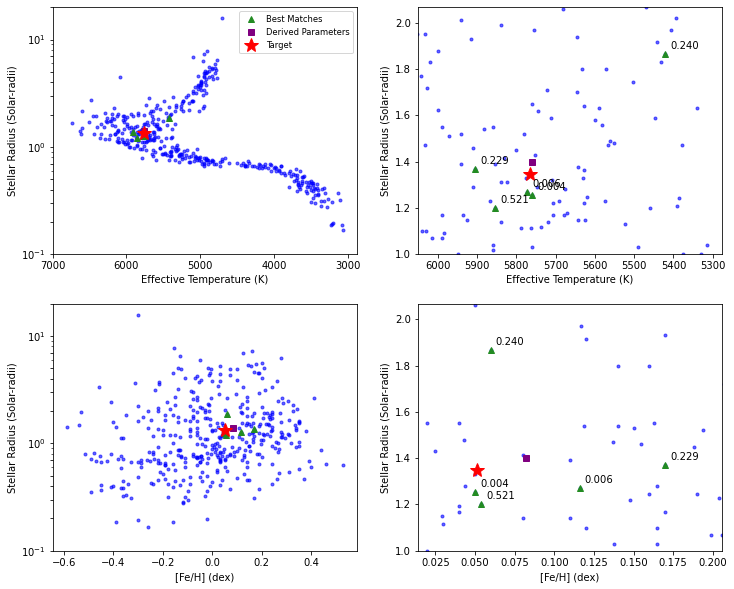

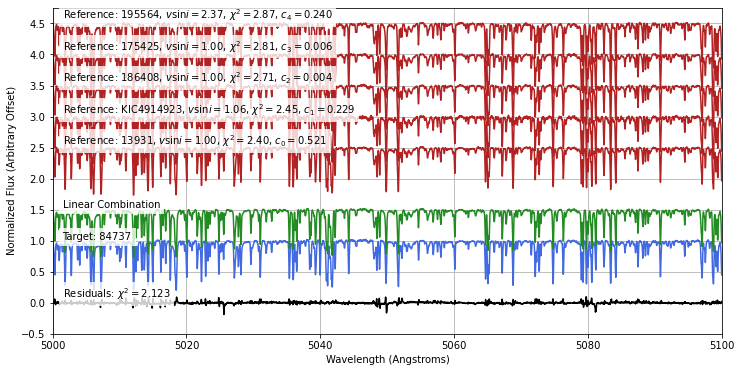

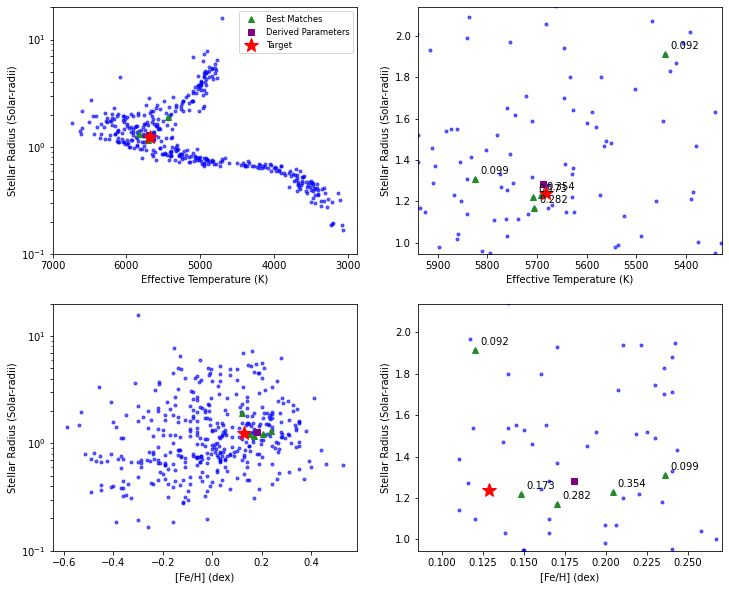

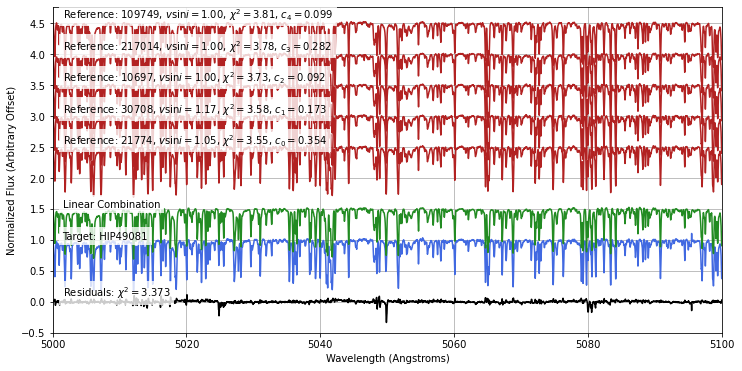

In [167]:
# -----------------------------------  ALL CODE BELOW THIS LINE ADDED BY ADZ -------------------------------------
# options
get_only_NDR = False # only compute the normalized, deblazed, registered spectra (NOT YET IMPLEMENTED -- use get_all_NDR_corrected.ipynb)
get_properties = True # run SM-Emp and output the stellar property results 
get_resids = True # run SM-Emp and output the residuals
run_iso = True # run SM-Emp and run isochrone analysis to determine additional stellar properties
save_SM_object = False # to save the Specmatch objects themselves
display_plots = False # to make plots
residuals_out_path = 'APF_spectra/NDRR_calib/' # directory to save residuals to 
properties_out_path = 'SM_stellar_properties/' # directory to save steller property results to
results_filename = 'specmatch_results_calib.csv' # filename for stellar property results within properties_out_path dir
plots_out_path =  'SM_output_plots_calib/' # directory to save plots to
properties_plots_path = plots_out_path + 'Stellar_properties/' # directory for property plots
spectra_plots_path = plots_out_path + 'Ref_lincomb_spectra/' # directory for spectra plots

# rename existing output files 
dt = datetime.datetime.now()
timestamp = dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '-' + dt.strftime("%X")
if os.path.isdir(residuals_out_path):
    os.rename(residuals_out_path, residuals_out_path[:-1] + '_' + timestamp)
result_path = properties_out_path + results_filename
if os.path.isfile(result_path):
    os.rename(result_path, result_path.split('.')[0] + '_' + timestamp + '.csv')  
if os.path.isdir(properties_plots_path):
    os.rename(properties_plots_path, properties_plots_path[:-1] + '_' + timestamp)
if os.path.isdir(spectra_plots_path):    
    os.rename(spectra_plots_path, spectra_plots_path[:-1] + '_' + timestamp)

# create output directories
os.mkdir(residuals_out_path)
if not os.path.isdir(plots_out_path): os.mkdir(plots_out_path)
os.mkdir(properties_plots_path)
os.mkdir(spectra_plots_path)

# add a warnings field to save with results.
warnings = []

#  Get spectra filelist
path_to_dir = input('Enter the path to the directory that contains the spectra: ') 
filelist = os.listdir(path_to_dir)
#filelist = filelist[0:20] # for testing to save time only run on this subset
# note if more than one spectra for a star, place in a subdirectory. 
try:
    filelist.remove('.ipynb_checkpoints') # remove hidden file in this directory
    filelist.remove('HIP5643_spectra') # remove problematic spectrum; produces an error but not due to labeling (GJ54.1)
except ValueError:
    pass
    
# for restarting a run if it has stopped partway through 
number_run = 40 # the number already successfully completed
#filelist = filelist[number_run:]
filelist = filelist[38:41]

    
# send output to 'specmatch_output.txt' (this is a log file for the current run)
# CAUTION! Deletes existing log files
if os.path.exists("specmatch_output.txt"):
    os.remove("specmatch_output.txt")
old_stdout = sys.stdout
sys.stdout = open('specmatch_output.txt', 'w')

# get wavelengths for residuals 
#wl_regions = [[5000,5100],[5101,5200],[5201,5300],[5301,5400],[5401,5500],[5501,5600],[5601,5700],[5701,5800],[5801,5900]]
#region_lens = [5835, 5722, 5612, 5508, 5406, 5309, 5216, 5124, 5037]
#wl_all_regions = np.zeros([0,0])
#for n in range(9): 
#    wl = np.linspace(wl_regions[n][0], wl_regions[n][1], region_lens[n])
#    wl_all_regions = np.append(wl_all_regions, wl) 

#lib = specmatchemp.library.read_hdf() # Moved below so can remove stars and replace after running each star

# Run Specmatch-emp and save results, normalized, deblazed, registered target, and residuals
nameslist = []
pixel_shifts = []
empty_dirs = []
for filename in filelist:   
    print(filename)
       
    # get list of filenames used for this star for logging in the results file    
    path_name = str(path_to_dir) + '/' + filename
    try:
        filenames = [f for f in listdir(path_name) if isfile(join(path_name, f))]
    except NotADirectoryError: # path to one file
        path_split = path_name.split('/')
        filenames = path_split[-1]
    
    # get HIP star name from filename
    apf_name_conversion = pd.read_csv('apf_name_conversion_updated.csv')
    apf_log_file = pd.read_csv('./apf_log_full_16Aug2021.csv')
    if filename.startswith('HIP'): # is a directory of spectra
        HIP_name = filename.split('_')[0] 
        if len(os.listdir(path_to_dir + '/' + filename)) < 1:
            print('Skipping ' + filename + ' due to empty directory.')
            empty_dirs += [filename]
            continue 
    elif filename.endswith('fits'): # is a single spectrum
        try:
            row = apf_log_file[apf_log_file['Filename'] == (filename.split('.')[0] + '.' + filename.split('.')[1] + '.fits')]
            HIP_name = row['HIP_name'].values.tolist()[0]
            if HIP_name == 'None': raise HIP_name_Exception('HIP_name \'None\' in APF log')
        except (IndexError, HIP_name_Exception): # File is not is BL APF database log file or HIP name is None
            row = apf_name_conversion[apf_name_conversion['FILENAME'] == (filename.split('.')[0] + '.' + filename.split('.')[1])]
            HIP_name = row['HIP_NAME'].values.tolist()[0]

    # get the Gaia and 2MASS (for later isochrone analysis) names, and get certain Gaia properties
   # try:  
    gaia_source_id, id_2MASS = get_names(HIP_name)
    if os.path.exists('gaia_values.csv'): 
        gaia_values = pd.read_csv('gaia_values.csv')
        if gaia_values['source_id'].isin([gaia_source_id]).any(): # if this star already exists in the gaia csv file
            gaia_data = gaia_values.loc[gaia_values['source_id'] == gaia_source_id]
        else: # query gaia for the values and add this star to the gaia csv file
            gaia_data = query_gaia_data(gaia_source_id)
            gaia_data.to_pandas().to_csv('gaia_values.csv', mode='a', header=False)
    else: # create the csv file, query gaia for the values and add this star to the gaia csv file
        gaia_data = query_gaia_data(gaia_source_id)
        gaia_data.to_pandas().to_csv('gaia_values.csv', mode='w')

    # read in Gaia properties (for later isochrone analysis)
    parallax = float(gaia_data['parallax']) #[mas --> milliarsec]
    u_parallax = float(gaia_data['parallax_error']) #[mas]
    ra = float(gaia_data['ra']) #[deg]
    dec = float(gaia_data['dec'])  #[deg]
    #except (AttributeError, ValueError): # the HIP name was not resolved in Simbad, for instance
    #    warnings += ['Failed to query Gaia or 2MASS (possibly name not resolved by Simbad); cannot run isochrone analysis.']
     #   run_iso = False     
     #   print('Failed to query Gaia catalog, possibly because name not resolved by Simbad.')
     #   pass
          
    # get the 2MASS photometry
    try:
        query2 = "SELECT designation,ra,dec,k_m,h_m,j_m,k_msigcom,h_msigcom,j_msigcom FROM fp_psc WHERE designation = '" + str(id_2MASS) + "'"
        service = pyvo.dal.TAPService('https://irsa.ipac.caltech.edu/TAP')
        phot_results = service.run_async(query2)
    except Exception:
        warnings += ['Failed to acquire 2MASS photometry; cannot run isochrone analysis.']
        run_iso = False  
        print('Failed to query for 2MASS photometry.')
        pass
        
    # flag stars outside library bounds in Teff and R (becuase these won't produce great matches)
    try:
        #gaia_Teff = float(gaia_data[gaia_data['HIP_name'] == HIP_name]['teff_val'])
        gaia_Teff = float(gaia_data['teff_val'])
        Teff_bounds_flag = int((gaia_Teff < 3056) or (gaia_Teff > 6738)) # 1 if outside library bounds in Teff
        if np.isnan(gaia_Teff):
            Teff_bounds_flag = 3 # 3 == could not find Teff value for star in Gaia (b/c this star is missing Teff)
    except Exception:
        Teff_bounds_flag = 3 # 3 == could not find Teff value for star in Gaia (b/c this star is not in the Gaia list)
    try:
        gaia_R = float(gaia_data['radius_val'])
        R_bounds_flag = int((gaia_R < 0.168) or (gaia_R > 15.781)) # 1 if outside library bounds in radius
        if np.isnan(gaia_R):
            R_bounds_flag = 3 # 3 == could not find Teff value for star in Gaia (b/c this star is missing Teff)
    except Exception:
        R_bounds_flag = 3 # 3 == could not find radius value for star in Gaia
    
    # Remove star from library (for use in calibration run)
    lib = library.read_hdf()
    idx_GL570B = lib.get_index('GL570B') # remove this one as it is in error according to S. Yee
    lib.pop(idx_GL570B)
    lib_names = lib.library_params['cps_name'].to_list()
    result_table = Simbad.query_objectids(HIP_name)
    alt_names = result_table.to_pandas()
    alt_names = alt_names.iloc[:,0].str.decode('utf-8') # gets rid of weird formatting
    if HIP_name == 'HIP80824': # This is the only GJ star (that we are running) that isn't listed in library as GL
        lib_name = 'GJ628'
    else: # get the library name
        lib_name = [name.replace(' ','').replace('HD','').replace('GJ','GL') for name in alt_names.to_list() if name.replace(' ','').replace('HD','').replace('GJ','GL') in lib_names]
    idx = lib.get_index(lib_name) # get the idx in the library
    if idx == []:
        print('Could not find star ' + HIP_name + ' in catalog in order to remove.')
    else:
        star = lib.pop(idx) # remove star from library
        print('For ' + HIP_name + ', removing corresponding star: ' + star[0]['cps_name'])
    
    # run Specmatch!
    try: 
        if get_only_NDR:
            # TO BE IMPLEMENTED (10/15/21). For now use the script get_all_NDR_corrected.ipynb for this purpose.
            print('\'get_only_NDR\' option not yet implemented. For now use the script get_all_NDR_corrected.ipynb for this purpose.')
            pass
            if not(get_resids) and not(run_SMEMP) and not(run_iso):
                continue

        if get_properties or get_resids or run_iso:       
            # run SM-Emp
            star_target, star_residual, wl_scale, use_header, obs_name, my_spectrum, sm,best_mean_chi_squared, options, SNR, iodine_flag = run_specmatch(str(path_to_dir) + '/' + filename, lib, display_plots) # Run Specmatch on each star  

        # save residual to fits file
        if get_resids:
            target_hdu = fits.PrimaryHDU(star_target, use_header)
            resid_hdu = fits.ImageHDU(star_residual)
            wl_hdu = fits.ImageHDU(wl_scale)
            hdu = fits.HDUList([target_hdu, resid_hdu, wl_hdu])
            hdu.writeto(residuals_out_path + HIP_name + '_' + obs_name + '_NDRR.fits')  

        # perform the isochrone analysis to determine better logg, mass, and age values
        iso_fail_flag = False
        if run_iso:
            try: 
                iso_results = run_isoclassify(sm, gaia_data, phot_results)
            except Exception:
                print('Isoclassify failed!')
                iso_fail_type, value, traceback = sys.exc_info()
                iso_fail_flag = True # Isoclassify failed to run on this star
                iso_fail_message = str(iso_fail_type).split('\'')[1] + ': ' + str(value)
                warnings += [iso_fail_message]
                # set the results to Nan
                iso_results = classify_grid.resdata() 
                iso_results.rad = np.nan
                iso_results.teff = np.nan
                iso_results.feh = np.nan
                iso_results.logg = np.nan
                iso_results.mass = np.nan
                iso_results.age = np.nan
        else: 
            # set the results to Nan as placeholders
            iso_results = classify_grid.resdata() 
            iso_results.rad = np.nan
            iso_results.teff = np.nan
            iso_results.feh = np.nan
            iso_results.logg = np.nan
            iso_results.mass = np.nan
            iso_results.age = np.nan

        # Record results to csv file
        # if not provided an output file name, specmatch_results.csv is written to
        # (and created if not already)
        #if (options.outputpath != None):
        #    if (not options.outputpath.endswith('.csv')):
        #        if (not options.outputpath.endswith('/')):
        #            options.outputpath += '/'
        #        options.outputpath += 'specmatch_results.csv'
        #    if isfile(options.outputpath):
        #        with open(options.outputpath,'a') as fd:
        #            write_results(fd, my_spectrum, sm, iso_results, HIP_name, filenames, Teff_bounds_flag, R_bounds_flag, SNR, iodine_flag)
        #    else:
        #        with open(options.outputpath, 'w', newline='') as fd:
        #            write_results(fd, my_spectrum, sm, iso_results, HIP_name, filenames, Teff_bounds_flag, R_bounds_flag, SNR, iodine_flag, write_new = True)
        #else:
        if get_properties:
            if isfile(properties_out_path + results_filename):
                with open(properties_out_path + results_filename,'a') as fd: 
                    #with open(properties_out_path + 'specmatch_results_detrended_test.csv','a') as fd_detrended:
                    write_results(fd, my_spectrum, sm, iso_results, HIP_name, filenames, Teff_bounds_flag, R_bounds_flag, SNR, iodine_flag, iso_fail_flag, warnings) 
            else:
                with open(properties_out_path + results_filename, 'w', newline='') as fd:
                   # with open(properties_out_path + 'specmatch_results_detrended_test.csv', 'w', newline='') as fd_detrended:
                   write_results(fd, my_spectrum, sm, iso_results, HIP_name, filenames, Teff_bounds_flag, R_bounds_flag, SNR, iodine_flag, iso_fail_flag, warnings, write_new = True)

        # find the (approximate) pixel shift used during shifting 
        # NOTE: this is currently not saved anywhere, and has not yet been shown to provide the correct shfit value! 
        pixel_shift = np.median(sm.shift_data['lag'])
        pixel_shifts = pixel_shifts + [pixel_shift]

        # Can save the entire SpecMatch object using: 
        if save_SM_object:
            save_sm_path = './Specmatch_objects/' + HIP_name + '.hdf'
            sm.to_hdf(save_sm_path)

    except Exception:
        print('SpecMatch-Emp failed!')
        fail_type, value, traceback = sys.exc_info()
        fail_code = 1 # SM-Emp failed to run on this star
        fail_message = str(fail_type).split('\'')[1] + ': ' + str(value)
        #if (options.outputpath != None):
        #   if (not options.outputpath.endswith('.csv')):
        #        if (not options.outputpath.endswith('/')):
        #            options.outputpath += '/'
        #        options.outputpath += 'specmatch_results.csv'
        #    if isfile(options.outputpath):
        #        with open(options.outputpath,'a') as fd:
        #            write_results_fail_case(fd, HIP_name, filenames, Teff_bounds_flag, R_bounds_flag, fail_code, fail_message, SNR, iodine_flag)
        #    else:
        #        with open(options.outputpath, 'w', newline='') as fd:
        #            write_results_fail_case(fd, HIP_name, filenames, Teff_bounds_flag, R_bounds_flag, fail_code, fail_message, SNR, iodine_flag, write_new = True)
        #else: 
        if get_properties:
            if isfile(properties_out_path + results_filename):
                with open(properties_out_path + results_filename,'a') as fd: 
                    #with open(properties_out_path + 'specmatch_results_detrended_test.csv','a') as fd_detrended:
                    write_results_fail_case(fd, HIP_name, filenames, Teff_bounds_flag, R_bounds_flag, fail_code, fail_message, SNR, iodine_flag, warnings)
            else:
                with open(properties_out_path + results_filename, 'w', newline='') as fd:
                   # with open(properties_out_path + 'specmatch_results_detrended_test.csv', 'w', newline='') as fd_detrended:
                   write_results_fail_case(fd, HIP_name, filenames, Teff_bounds_flag, R_bounds_flag, fail_code, fail_message, SNR, iodine_flag, warnings, write_new = True)

sys.stdout = old_stdout


In [10]:
# Save pixel shifts, if desired
#HIP_names = pd.read_csv('Star_list.csv')['HIP_NAME'].to_list()
#pix_shift_array = np.array(pixel_shifts)
#df = pd.DataFrame(pix_shift_array, index = HIP_names, columns =['Pixel_shifts']) 
#df.to_csv('Pixel_shifts.csv')

In [ ]:
#./APF_spectra/apf_spectra_highest_SNR/HIP93873_spectra
#./APF_spectra/apf_spectra_lite # for testing only
#./APF_spectra/apf_spectra_highest_SNR # for calibration set
#/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/apf_spectra_highest_SNR

In [ ]:
#ranw.242.NDR.fits (GJ 244), ranw.314.NDR.fits (HIP69673), ranx.273.NDR.fits (HIP83207) and raqt.232.NDR.fits (HIP91262)

# sandbox below here

In [59]:

np.where(filelist == 'HIP98767_spectra')

(array([], dtype=int64),)

In [63]:
len(filelist)

101

In [81]:
gaia_data =  pd.read_csv('./Gaia_properties_by_HIP_name.csv') 

In [66]:
(filename.split('.')[0] + '.' + filename.split('.')[1] + '.fits')

'raia.220.fits'

In [123]:
HIP_name = 'HIP30920' # --> should be 3
#HIP_name = 'HIP16537' # --> should be 0
#HIP_name = 'HIP0000'  # --> should be 3
#HIP_name = 'HIP1692' # --> should be 1
try:
    gaia_R = float(gaia_data[gaia_data['HIP_name'] == HIP_name]['radius_val'])
    R_bounds_flag = int((gaia_R < 0.168) or (gaia_R > 15.781)) # 1 if outside library bounds in radius
    if np.isnan(gaia_R):
        R_bounds_flag = 3 # 3 == could not find Teff value for star in Gaia (b/c this star is missing Teff)
except Exception:
    R_bounds_flag = 3 # 3 == could not find radius value for star in Gaia

In [124]:
R_bounds_flag

3

In [4]:
#HIP_name = 'HIP30920' # --> should be 3
#HIP_name = 'HIP16537' # --> should be 0
#HIP_name = 'HIP0000'  # --> should be 3
HIP_name = 'HIP1692' # --> should be 1

try:
    # get Gaia and 2MASS names (for creating flags and for later isochrone analysis)
    result_table = Simbad.query_objectids(HIP_name)
    names = result_table.to_pandas()['ID'].to_list()
    gaia_name = [name.decode('utf-8').split(' ')[-1] for name in names if name.decode('utf-8').startswith('Gaia DR2')]
    two_MASS_name = [name.decode('utf-8').split('J')[-1] for name in names if name.decode('utf-8').startswith('2MASS')]
    (gaia_source_id,) = gaia_name
    (id_2MASS,) = two_MASS_name

    # Gaia properties to flag stars outside library bounds
    #gaia_data =  pd.read_csv('./Gaia_properties_by_HIP_name.csv') # gaia stellar properties (only R and Teff)
    query1 = "SELECT source_id, ra, dec, parallax, parallax_error, teff_val, radius_val  FROM gaiadr2.gaia_source WHERE source_id = " + str(gaia_source_id)
    job = Gaia.launch_job(query1)
    gaia_data = job.get_results()
except AttributeError:
    pass
    
# flag stars outside library bounds in Teff and R (becuase these won't produce great matches)
try:
    #gaia_Teff = float(gaia_data[gaia_data['HIP_name'] == HIP_name]['teff_val'])
    gaia_Teff = float(gaia_data['teff_val'])
    Teff_bounds_flag = int((gaia_Teff < 3056) or (gaia_Teff > 6738)) # 1 if outside library bounds in Teff
    if np.isnan(gaia_Teff):
        Teff_bounds_flag = 3 # 3 == could not find Teff value for star in Gaia (b/c this star is missing Teff)
except Exception:
    Teff_bounds_flag = 3 # 3 == could not find Teff value for star in Gaia (b/c this star is not in the Gaia list)
try:
    gaia_R = float(gaia_data['radius_val'])
    R_bounds_flag = int((gaia_R < 0.168) or (gaia_R > 15.781)) # 1 if outside library bounds in radius
    if np.isnan(gaia_R):
        R_bounds_flag = 3 # 3 == could not find Teff value for star in Gaia (b/c this star is missing Teff)
except Exception:
    R_bounds_flag = 3 # 3 == could not find radius value for star in Gaia
        
print(Teff_bounds_flag)
print(R_bounds_flag)

0
1


In [32]:
# testing the Gaia csv file accessing and creating structure
if os.path.exists('gaia_values_test.csv'): 
    gaia_values = pd.read_csv('gaia_values_test.csv')
    if gaia_values['source_id'].isin([gaia_source_id]).any(): # if this star already exists in the gaia csv file
        gaia_data = gaia_values.loc[gaia_values['source_id'] == gaia_source_id]
        print('here1')
    else: # query gaia for the values and add this star to the gaia csv file
        try:
        # --- make the gaia data ---  #
        except AttributeError: # the HIP name was not resolved in Simbad, for instance
            gaia_data = 
        gaia_data.to_pandas().to_csv('gaia_values_test.csv', mode='a', header=False)
        print('here2')
else: # create the csv file, query gaia for the values and add this star to the gaia csv file
    # --- make the gaia data ---  #
    gaia_data.to_pandas().to_csv('gaia_values_test.csv', mode='w')
    print('here3')


here2


In [147]:
filename = 'raqn.201.fits'
row = apf_name_conversion[apf_name_conversion['FILENAME'] == (filename.split('.')[0] + '.' + filename.split('.')[1])]
HIP_name = row['HIP_NAME'].values.tolist()[0]

In [148]:
HIP_name

'HIP80824'

In [23]:
pd.read_csv('test.csv')['source_id']

0    2430036837596487424
1    2430036837596487424
Name: source_id, dtype: int64

In [33]:
gaia_data_df = pd.DataFrame([{'source_id':source 1, 'b': 2, 'c':3}])

source_id,ra,dec,parallax,parallax_error,teff_val,radius_val
,deg,deg,mas,mas,K,Rsun
int64,float64,float64,float64,float64,float32,float32
2430036837596487424,5.305588587314166,-8.281144249090133,1.299756736432399,0.048879578938018975,4445.0,22.816832


In [100]:
os.getcwd()

'/mnt_home/azuckerman/BL_APF_DAP'

In [99]:
plots_out_path

'SM_output_plots_calib/'

In [107]:
os.path.isdir('./' + 'SM_output_plots_calib/Ref_lincomb_spectra')

False

In [152]:
properties_plots_path = plots_out_path + 'Stellar_properties/' # directory for property plots
spectra_plots_path = plots_out_path + 'Ref_lincomb_spectra/' # directory for spectra plots

In [159]:

dt = datetime.datetime.now()
timestamp = dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '-' + dt.strftime("%X")

# clean up existing files 
if os.path.isdir(residuals_out_path):
    os.rename(residuals_out_path, residuals_out_path[:-1] + '_' + timestamp)
result_path = properties_out_path + results_filename
if os.path.isfile(result_path):
    os.rename(result_path, result_path.split('.')[0] + '_' + timestamp + '.csv')  
if os.path.isdir(properties_plots_path):
    os.rename(properties_plots_path, properties_plots_path[:-1] + '_' + timestamp)
if os.path.isdir(spectra_plots_path):    
    os.rename(spectra_plots_path, spectra_plots_path[:-1] + '_' + timestamp)

# create output directories
os.mkdir(residuals_out_path)
if not os.path.isdir(plots_out_path): os.mkdir(plots_out_path)
os.mkdir(properties_plots_path)
os.mkdir(spectra_plots_path)



In [154]:
properties_plots_path[:-1]

'SM_output_plots_calib/Stellar_properties'

In [148]:
residuals_out_path.split('/')[:-1]

['APF_spectra', 'NDRR_calib']